# 第六章  提取表格
 - [一、引言](#一、引言)
 - [二、代码示例](#二、代码示例)
     - [2.1、导入模块](#2.1、导入模块)
     - [2.2、查看文档](#2.2、查看文档)
     - [2.3、使用Unstructured API 提取PDF文档中的表格](#2.3、使用Unstructured-API-提取PDF文档中的表格)
     - [2.4、查看和展示提取的表格](#2.4、查看和展示提取的表格)
     - [2.5、对提取的表格进行描述](#2.5、对提取的表格进行描述)


## 一、引言
***
大多数<strong>检索增强生成(Retrieval-Augmented Generation, RAG)</strong>应用主要关注文档中的文本内容。但在特定行业，文档中的结构化数据也非常重要。比如金融和保险行业会用到文档中的表格信息。为了实现针对表格的问答查询，我们需要对文档中的表格进行提出。

在本章节中，您将学习如何从文档中提取表格并推断其结构。表格数据在不文档类型中的提取有所不同。
- 在HTML和Word文档，在文档本身中包含表格结构信息。例如，在HTML的表格标签中。这些文档类型可以使用基于规则的解析器来提取表格信息。
- 在PDF和图像文档中，需要使用视觉识别来先识别文档中的表格，然后从表格中提取信息。


视觉识别常见的工具包括表格转换器（Table Transformers）, 视觉转换器（Vision Transformers）, 以及光学字符识别(Optical Character Recognition，OCR)。

- 表格转换器识别表格单元的边界框，然后将输出转换为HTML。优点在于能够追溯每个单元格的原始边框信息。缺点是需要多次调用昂贵的模型，包文档布局检测模型和OCR模型。

- 我们也可以使用前面章节已经学习到的视觉转换器来提取表格，并输出为HTML格式。该方法的优点是允许使用和设计提示(Prompting)，灵活性更高，并且只涉及单次模型调用。缺点是它是生成性的，容易出现错误，并且不会保留任何边界框信息。

- 光学字符识别方法先通过OCR识别文档，然后基于OCR的输出, 检查模式和规律来构建表格结构。对于结构比较清晰的表格，这种方法处理起来块且精确。由于其使用基于统计和规则的方法进行检测，使得其缺乏灵活性。同时，这种方法也没有办法追溯每个单元格的原始边框信息。


## 二、代码示例
***

### 2.1、导入模块

In [1]:
# 导入警告控制模块，忽略警告的输出。
# 这让输出的结果看起来更干净
import warnings
warnings.filterwarnings("ignore")


# 如果你还没有API Key, 你可以去官网进行申请 https://unstructured.io/api-key-free
# 你需要在文件目录下创建一个.env的文件，文件中存放你的 DLAI_API_KEY=“your unstructured API Key”
# 然后通过 get_dlai_api_key 加载并获取环境变量 DLAI_API_KEY
from Utils_Ch6 import Utils
DLAI_API_KEY = Utils().get_dlai_api_key()


from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError
from unstructured.staging.base import dict_to_elements

### 2.2、查看文档

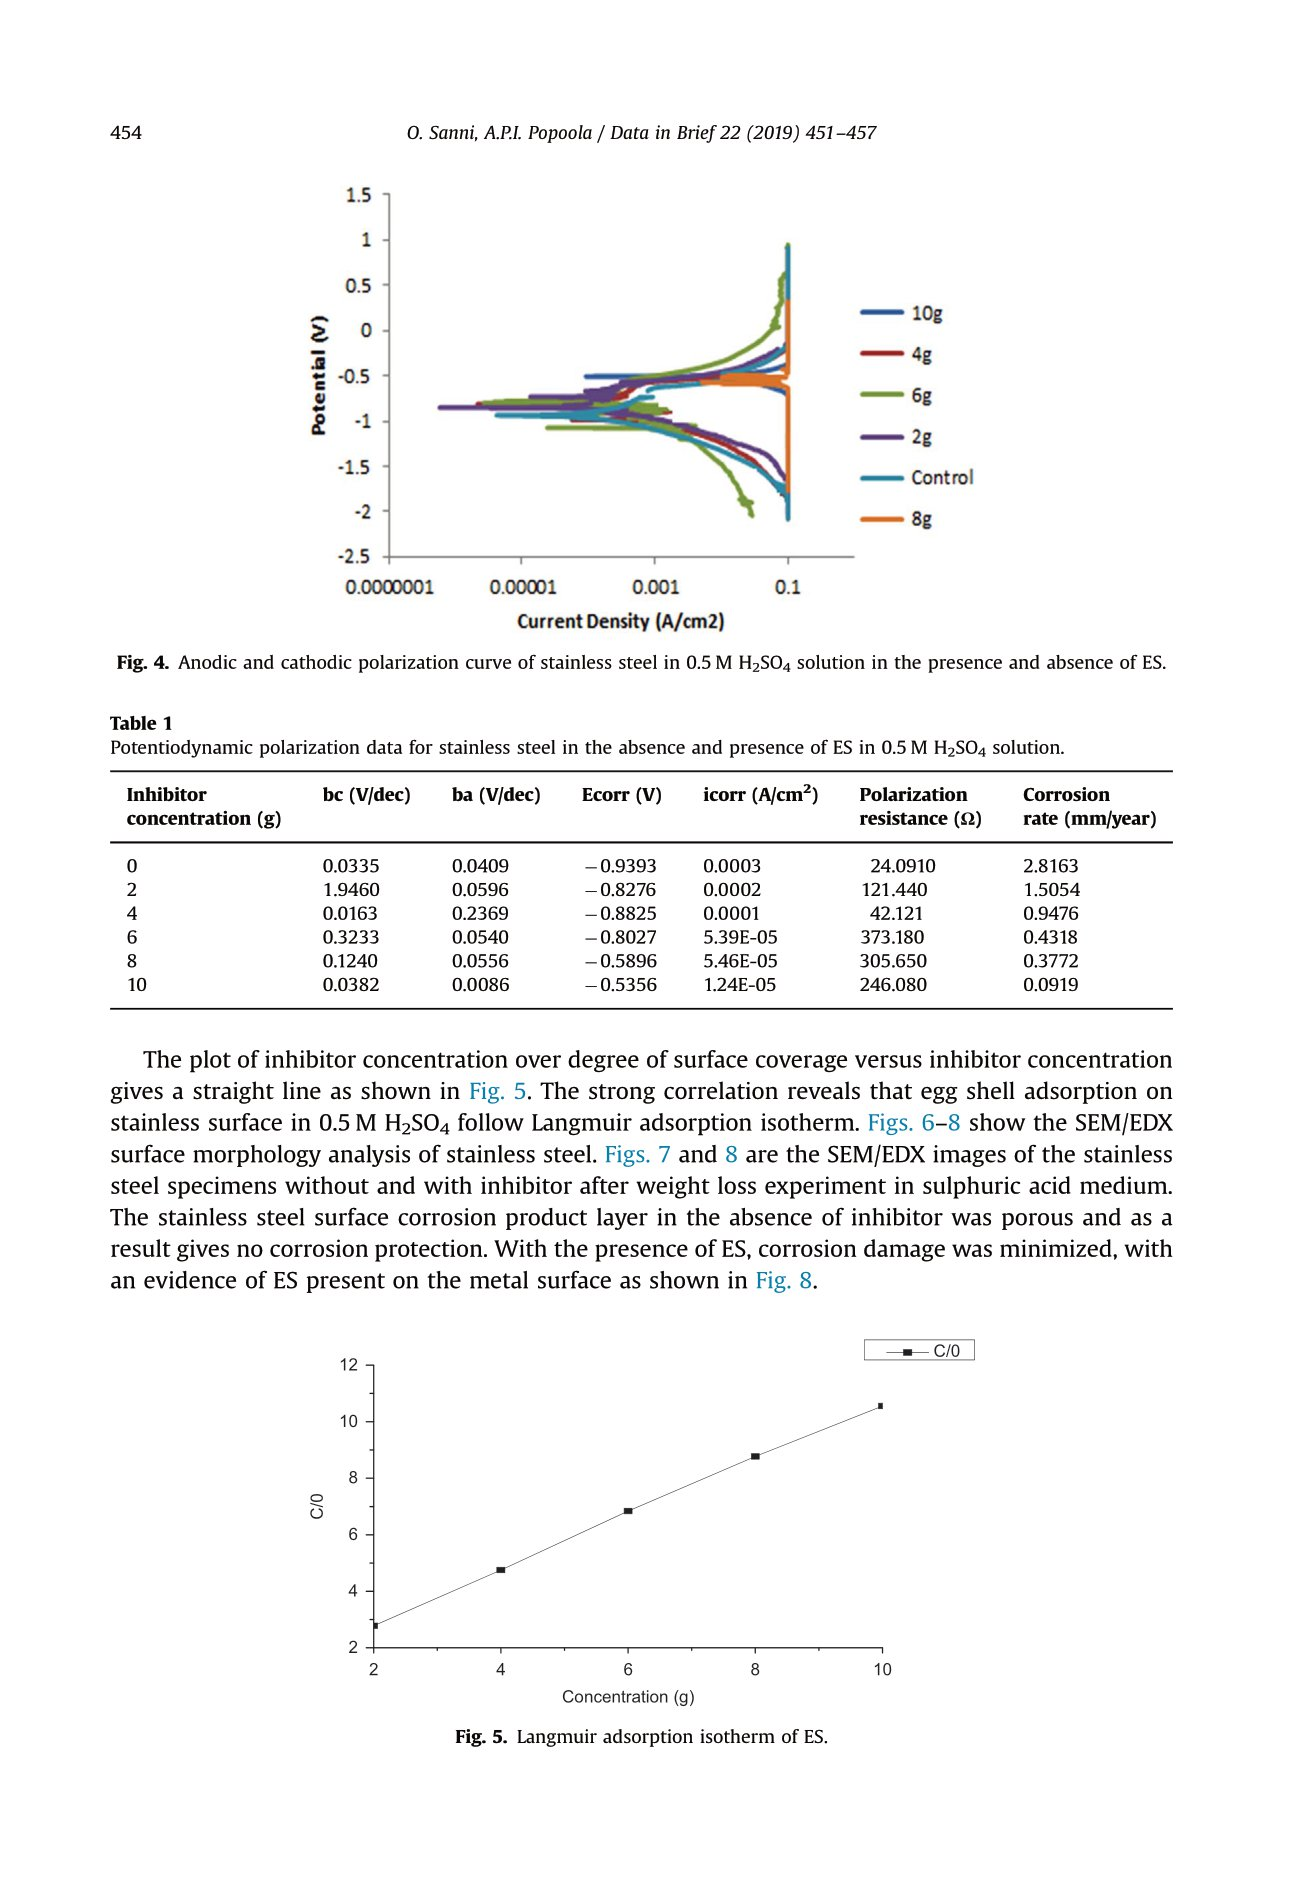

In [2]:
from IPython.display import Image

Image(filename="images/embedded-images-tables.jpg", height=1000, width=1000)

### 2.3、使用Unstructured API 提取PDF文档中的表格

In [3]:
# 读入 PDF 文档内容
filename = "example_files/embedded-images-tables.pdf"
with open(filename, "rb") as f:
    content = f.read()
    
# 构建 unstructured 自定义文件格式
files = shared.Files(content=content, file_name=filename)

# 查看类型
type(files)

unstructured_client.models.shared.partition_parameters.Files

In [4]:
# 初始化 UnstructuredClient
s = UnstructuredClient(api_key_auth=DLAI_API_KEY)

# 定义参数，这些参数将被 Unstructured API 用于解析 PDF
req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
    skip_infer_table_types=[],
    pdf_infer_table_structure=True,
)


try:
    # 进行 API 请求，发送定义好的参数，返回结果(resp)
    resp = s.general.partition(req)
    
    # 将结果进行格式转换
    elements = dict_to_elements(resp.elements)
    
except SDKError as e:
    # 如过请求失败，打印错误信息
    print(e)

In [5]:
print()
print("解析得到的结果中包含以下类型：", set([el.category for el in elements]))
print()


解析得到的结果中包含以下类型： {'ListItem', 'Header', 'Image', 'Title', 'Table', 'UncategorizedText', 'FigureCaption', 'NarrativeText'}



In [6]:
# 提取类型为表格的元素
tables = [el for el in elements if el.category == "Table"]
print("一共提取%s个表格" %len(tables))

一共提取1个表格


### 2.4、查看和展示提取的表格

In [7]:
# 查看第一个表格的文本
tables[0].text

'Inhibitor Polarization Corrosion be (V/dec) ba (V/dec) Ecorr (V) icorr (AJcm?) concentration (g) resistance (Q) rate (mmj/year) 0.0335 0.0409 —0.9393 0.0003 24.0910 2.8163 1.9460 0.0596 .8276 0.0002 121.440 1.5054 0.0163 0.2369 .8825 0.0001 42121 0.9476 s NO 03233 0.0540 —0.8027 5.39E-05 373.180 0.4318 0.1240 0.0556 .5896 5.46E-05 305.650 0.3772 = 5 0.0382 0.0086 .5356 1.24E-05 246.080 0.0919'

In [8]:
# 得到第一个表格的文本元数据，输出为 HTML 格式
table_html = tables[0].metadata.text_as_html

In [9]:
from io import StringIO
from lxml import etree

# 使用 lxml 对表格的文本元数据进行解析
parser = etree.XMLParser(remove_blank_text=True)
file_obj = StringIO(table_html)
tree = etree.parse(file_obj, parser)

# 将解析的结果以结构化的方式打印输出
print(etree.tostring(tree, pretty_print=True).decode())

<table>
  <thead>
    <th>Inhibitor concentration (g)</th>
    <th>be (V/dec)</th>
    <th>ba (V/dec)</th>
    <th>Ecorr (V)</th>
    <th>icorr (AJcm?)</th>
    <th>Polarization resistance (Q)</th>
    <th>Corrosion rate (mmj/year)</th>
  </thead>
  <tr>
    <td/>
    <td>0.0335</td>
    <td>0.0409</td>
    <td>&#8212;0.9393</td>
    <td>0.0003</td>
    <td>24.0910</td>
    <td>2.8163</td>
  </tr>
  <tr>
    <td>NO</td>
    <td>1.9460</td>
    <td>0.0596</td>
    <td>&#8212;0.8276</td>
    <td>0.0002</td>
    <td>121.440</td>
    <td>1.5054</td>
  </tr>
  <tr>
    <td/>
    <td>0.0163</td>
    <td>0.2369</td>
    <td>&#8212;0.8825</td>
    <td>0.0001</td>
    <td>42121</td>
    <td>0.9476</td>
  </tr>
  <tr>
    <td>s</td>
    <td>03233</td>
    <td>0.0540</td>
    <td>&#8212;0.8027</td>
    <td>5.39E-05</td>
    <td>373.180</td>
    <td>0.4318</td>
  </tr>
  <tr>
    <td/>
    <td>0.1240</td>
    <td>0.0556</td>
    <td>&#8212;0.5896</td>
    <td>5.46E-05</td>
    <td>305.650</td>
   

In [10]:
from IPython.core.display import HTML

# 使用IPython的模块对 HTML 格式的表格进行展示
HTML(table_html)

,0.0335,0.0409,—0.9393,0.0003,24.0910,2.8163
NO,1.9460,0.0596,—0.8276,0.0002,121.440,1.5054
,0.0163,0.2369,—0.8825,0.0001,42121,0.9476
s,03233,0.0540,—0.8027,5.39E-05,373.180,0.4318
,0.1240,0.0556,—0.5896,5.46E-05,305.650,0.3772
= 5,0.0382,0.0086,—0.5356,1.24E-05,246.080,0.0919


### 2.5、对提取的表格进行描述

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain.chains.summarize import load_summarize_chain

In [12]:
# 初始化模型
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106")
chain = load_summarize_chain(llm, chain_type="stuff")
chain.invoke([Document(page_content=table_html)])

{'input_documents': [Document(page_content='<table><thead><th>Inhibitor concentration (g)</th><th>be (V/dec)</th><th>ba (V/dec)</th><th>Ecorr (V)</th><th>icorr (AJcm?)</th><th>Polarization resistance (Q)</th><th>Corrosion rate (mmj/year)</th></thead><tr><td></td><td>0.0335</td><td>0.0409</td><td>—0.9393</td><td>0.0003</td><td>24.0910</td><td>2.8163</td></tr><tr><td>NO</td><td>1.9460</td><td>0.0596</td><td>—0.8276</td><td>0.0002</td><td>121.440</td><td>1.5054</td></tr><tr><td></td><td>0.0163</td><td>0.2369</td><td>—0.8825</td><td>0.0001</td><td>42121</td><td>0.9476</td></tr><tr><td>s</td><td>03233</td><td>0.0540</td><td>—0.8027</td><td>5.39E-05</td><td>373.180</td><td>0.4318</td></tr><tr><td></td><td>0.1240</td><td>0.0556</td><td>—0.5896</td><td>5.46E-05</td><td>305.650</td><td>0.3772</td></tr><tr><td>= 5</td><td>0.0382</td><td>0.0086</td><td>—0.5356</td><td>1.24E-05</td><td>246.080</td><td>0.0919</td></tr></table>')],
 'output_text': 'The table provides data on inhibitor concentration,